<a href="https://colab.research.google.com/github/LarsHadidi/PRONTO/blob/mathprogram/PDP-MIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Progressive Dinner Party: Mixed Integer Program

## Hosted Runtime

Connect to NEOS Server with the Kestrel interface.

In [ ]:
!pip install -q amplpy
from amplpy import AMPL

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 43.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 7.8 MB/s eta 0:00:00


## Local Runtime

`jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0`

## Imports

In [1]:
import itertools
import numpy as np
import pandas as pd
import networkx as nx
import ipywidgets as widgets
import matplotlib.pyplot as plt

## Formulation

\begin{array}{|c|c|}
\hline
C_{ij} \in \mathbb{R}^2&  \text{Costs of travelling from node i to node j}  \\[1em] 
\hline
e_{ij} \in \mathbb{B}^2 & \text{Element of the adjacency matrix indicating if there should be link between node i and node j} \\[1em]
\hline
s_i \in \mathbb{B} &  \text{Indicator, if node i hosts starters course} \\[1em]
\hline
m_i \in \mathbb{B} &  \text{Indicator, if node i hosts main course } \\[1em]
\hline
d_i \in \mathbb{B} &  \text{Indicator, if node i hosts desert course} \\[1em]
\hline
{}_{l}t_{ijk} \in \mathbb{B}^4& \text{Element of Tour-Tensor, indicating if $(i,j,k)$ is the $l^{\text{th}}$ tour}  \\[1em]
\hline
\end{array}

\begin{array}{|l|c|c|c|c|}
\hline
\textbf{Constraint} & \textbf{Meaning} & \textbf{Count} & \textbf{Summands} \\[2em]
\hline
∀ i:\hspace{1em} s_i + m_i + d_i = 1 & \text{unique node class} & N & 3 \\[2em]
\hline
∀ i: \sum\limits_j s_i e_{ji} = 0 & \text{no inbound links on starter node} & N & N \\[2em]
\hline
∀ i: \sum\limits_j s_i e_{ij} = 3 s_i & \text{three outbound links on starter node} & N & N \\[2em]
\hline
∀ i: \sum\limits_j m_i e_{ji} = 3 m_i & \text{three inbound links on main node} & N & N \\[2em]
\hline
∀ i: \sum\limits_j m_i e_{ij} = 3 m_i & \text{three outbound links on main node} & N & N \\[2em]
\hline
∀ i: \sum\limits_j d_i e_{ji} = 3 d_i & \text{three inbound links on desert node} & N & N \\[2em]
\hline
∀ i: \sum\limits_j d_i e_{ij} = 0 & \text{no outbound links on desert node} & N & N \\[2em]
\hline
3 \cdot \sum\limits_i m_i = N & \text{equal class partitions} & 1 & 3N \\[2em]
\hline
∀ l: \sum\limits_{i,j,k} {}_{l}t_{ijk} = 1 & \text{unique tour per label} & N & N^3 \\[2em]
\hline
∀ i,j:\hspace{1em} s_i e_{ij} + d_j \leq 1 & \text{no shortcuts from $s$ to $d$} & N^2 & 2 \\[2em]
\hline
∀ l: ∀ i,j,k:\hspace{1em} {}_{l}t_{ijk} \leq e_{ij}e_{jk} & \text{valid tour} & N^4 & 1 \\[2em]
\hline
\begin{align*}
\forall p,q,p \neq q:&\hspace{1em}
    \sum_i \left(\sum_{j,k} {}_{p}t_{ijk} + \sum_{j,k} {}_{q}t_{ijk}\right)^2 \\
    &+\sum_j \left(\sum_{i,k} {}_{p}t_{ijk} + \sum_{i,k} {}_{q}t_{ijk}\right)^2
    \\
    &+\sum_k \left(\sum_{i,j} {}_{p}t_{ijk} + \sum_{i,j} {}_{q}t_{ijk}\right)^2
    \leq 8
\end{align*}
& \text{limit encounters} & N^2-N & 12N^5 \\[2em]
\hline
\end{array}

## Implementation

In [2]:
%%writefile pdp.mod
problem progressive_dinner_party;
#--------------------------------

set N;
set T = {N,N,N};
param C{N,N};

var s{N} binary;
var m{N} binary;
var d{N} binary;
var e{N,N} binary;
var t{N,T} binary;

minimize objective:
	sum {i in N, j in N} C[i,j]*e[i,j];

subject to classes {i in N}:
	s[i] + m[i] + d[i] = 1;
	
subject to inflow_s {i in N}:
	sum {j in N} s[i] * e[j,i] = 0;
	
subject to outflow_s {i in N}:
	sum {j in N} s[i] * e[i,j] = 3 * s[i];
	
subject to inflow_m {i in N}:
	sum {j in N} m[i] * e[j,i] = 3 * m[i];
	
subject to outflow_m {i in N}:
	sum {j in N} m[i] * e[i,j] = 3 * m[i];
	
subject to inflow_d {i in N}:
	sum {j in N} d[i] * e[j,i] = 3 * d[i];
	
subject to outflow_d {i in N}:
	sum {j in N} d[i] * e[i,j] = 0;
	
subject to shortcut {i in N, j in N}:
	s[i] * e[i,j] + d[j] <= 1;
	
subject to equipartition:
	3 * sum {i in N} m[i] = card(N);

subject to tour {label in N, (i,j,k) in T}:
	t[label, i,j,k] <= e[i,j]*e[j,k];

subject to unique {label in N}:
	sum {(i,j,k) in T} t[label, i,j,k] = 1;

subject to encounters {p in N, q in N: p <> q}:
		sum {i in N} (sum {j in N, k in N} t[p, i,j,k] + sum {j in N, k in N} t[q, i,j,k])*(sum {j in N, k in N} t[p, i,j,k] + sum {j in N, k in N} t[q, i,j,k]) 
	+ sum {j in N} (sum {i in N, k in N} t[p, i,j,k] + sum {i in N, k in N} t[q, i,j,k])*(sum {i in N, k in N} t[p, i,j,k] + sum {i in N, k in N} t[q, i,j,k])
	+ sum {k in N} (sum {i in N, j in N} t[p, i,j,k] + sum {i in N, j in N} t[q, i,j,k])*(sum {i in N, j in N} t[p, i,j,k] + sum {i in N, j in N} t[q, i,j,k])
	<= 8;

Overwriting pdp.mod


## Data

In [3]:
w_size = widgets.IntText(description='Size', orientation='horizontal', value=9, min=9)
w_cluster = widgets.IntText(description='Clusters', orientation='horizontal', value=1, min=1)
w_deviation = widgets.FloatText(description='Deviation', orientation='horizontal', value=0.1, min=0)
w_scale = widgets.IntText(description='Scaling', orientation='horizontal', value=1)
display(widgets.Box([w_size, w_cluster,w_deviation, w_scale], layout=widgets.Layout(display='flex', flex_flow='row')))

Box(children=(IntText(value=9, description='Size'), IntText(value=1, description='Clusters'), FloatText(value=…

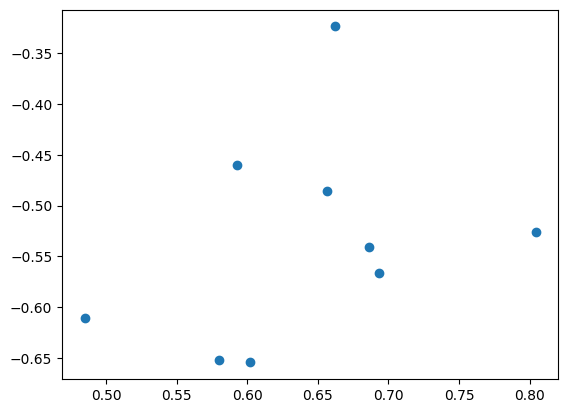

In [4]:
rng = np.random.default_rng()

N = w_size.value
K = w_cluster.value
σ = w_deviation.value
λ = w_scale.value

assert N >= 9
assert K > 0
assert N % K == 0
assert N % 3 == 0
assert σ >= 0
assert λ > 0

points = {}
centers = rng.uniform(-1, 1, (K, 2))
for i in range(K):
	points[str(centers[i])] = λ * rng.normal(centers[i], σ, (N // K, 2))

X = np.array(list(points.values())).reshape(N, 2)[:,0]
Y = np.array(list(points.values())).reshape(N, 2)[:,1]

G = nx.DiGraph()
for i in range(N):
	G.add_node(i, x = X[i], y = Y[i])

C = np.empty((N,N))
for a,b in itertools.product(range(N), range(N)):
	dX = (X[b]-X[a]) * (X[b]-X[a])
	dY = (Y[b]-Y[a]) * (Y[b]-Y[a])
	C[a,b] = np.sqrt(dX + dY)

plt.scatter(X,Y)
plt.show()

In [5]:
with open('pdp.dat', 'w') as f:
	f.write('set N :=')
	for n in range(1, N + 1):
		f.write(f' {n}')
	f.write(';\n')
	f.write('param C :=\n')
	for i,j in itertools.product(range(N), range(N)):
		f.write(f'{i+1} {j+1} {C[i,j]}\n')
	f.write(';')

## Solver

In [6]:
from amplpy import AMPL

In [7]:
ampl = AMPL()

In [8]:
ampl.setOption('solver', 'gurobi')
ampl.setOption('gurobi_options', 'outlev=1 presolve=2 mipfocus=2 mipgap=0.2')
ampl.setOption('solution_round', '0')

In [9]:
ampl.read('pdp.mod')

In [10]:
ampl.read_data('pdp.dat')

In [11]:
ampl.solve()

x-Gurobi 10.0.0: Set parameter OutputFlag to value 1
Set parameter Presolve to value 2
Set parameter MIPFocus to value 2
Set parameter MIPGap to value 0.2
Set parameter InfUnbdInfo to value 1
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 19 rows, 6669 columns and 6597 nonzeros
Model fingerprint: 0x9796dae9
Model has 6768 quadratic constraints
Variable types: 0 continuous, 6669 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  QMatrix range    [1e+00, 6e+00]
  QLMatrix range   [1e+00, 3e+00]
  Objective range  [2e-02, 3e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+00]
  QRHS range       [1e+00, 8e+00]

User MIP start did not produce a new incumbent solution
User MIP start violates constraint R0 by 1.000000000
Processed MIP start in 4.

In [12]:
s = ampl.get_variable('s').get_values()
m = ampl.get_variable('m').get_values()
d = ampl.get_variable('d').get_values()
e = ampl.get_variable('e').get_values()
t = ampl.get_variable('t').get_values()

S = np.array(s.get_column('s.val').to_list())
M = np.array(m.get_column('m.val').to_list())
D = np.array(d.get_column('d.val').to_list())
E = np.reshape(e.get_column('e.val').to_list(), (N,N))
T = np.reshape(t.get_column('t.val').to_list(), (N,N,N,N))

## Results

In [14]:
def draw_graph(nodes: dict, edges: list[tuple]):
	G = nx.DiGraph()
	G.add_nodes_from(nodes)
	G.add_edges_from(edges)
	pos = {k: list(v.values()) for k, v in nodes.items()}
	edge_colors = nx.get_edge_attributes(G,'color').values()
	node_colors = np.array(list(dict(G.in_degree(G.nodes)).values())) - np.array(list(dict(G.out_degree(G.nodes)).values()))
  

	nx.draw(
			G, pos,
			edge_color = edge_colors,
			edge_cmap = plt.cm.get_cmap('Set3'),
			node_color = node_colors,
			width=3, node_size=50, connectionstyle='arc3,rad=0.1')
	plt.show()

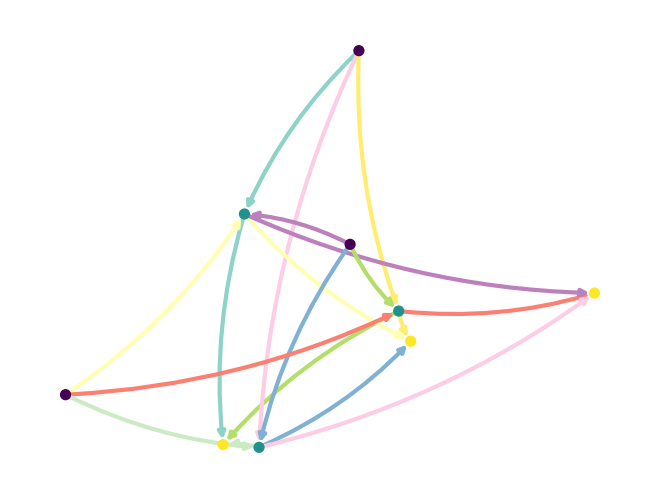

In [16]:
tours = [(l,i,j,k) for l in range(N) for i in range(N) for j in range(N) for k in range(N) if T[l, i,j,k] == 1]
edges = []
for (l,i,j,k) in tours:
	edges.append((i, j, {'color':l}))
	edges.append((j, k, {'color':l}))

nodes = dict(G.nodes(data=True))

draw_graph(nodes, edges)

The given QCBP is linerizable to a MILP.

The decision variables' count scales to the order of four.

The "limit encounters" constraint's amount of summands scales to the order of five.

Therefore, this formulation scales poorly.